In [41]:
%load_ext autoreload
%autoreload 2
import sys, os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor

sys.path.insert(0, os.path.join("..", "src"))
from augmentation import TransformData

import warnings

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def smape(a, f):
    return np.sum(np.abs(f - a)) / np.sum(f + a)

## Data generating

In [43]:
changes = {200: 8, 520: 2, 580: 3, 660: 5}

rnd_koeff = 10
ln = 24 * 30 * 1

np.random.seed(2021)
x = [
    (40 + 40 * math.sin(x / 10) + rnd_koeff * (np.random.rand() - 0.5))
    for x in range(ln)
]
np.random.seed(2022)
y = [
    (100 + 40 * math.sin(x / 10) + 2 * rnd_koeff * (np.random.rand() - 0.5))
    for x in range(ln)
]

for i in range(ln):
    if i % 10 != 0:
        y[i] = np.nan

for n, multy in changes.items():
    x[n] *= multy
    y[n] *= multy

dt = [datetime(2021, 1, 1) + timedelta(hours=x) for x in range(ln)]

df = pd.DataFrame({"time": dt, "x": x, "y": y})
train_test_split = datetime(2021, 1, 20)

## Let's look at the data

In [44]:
df.head()

,time,x,y
0,2021-01-01 00:00:00,41.059783,90.187172
1,2021-01-01 01:00:00,46.327030,NaN
2,2021-01-01 02:00:00,44.336245,NaN
3,2021-01-01 03:00:00,49.947539,NaN
4,2021-01-01 04:00:00,60.549167,NaN


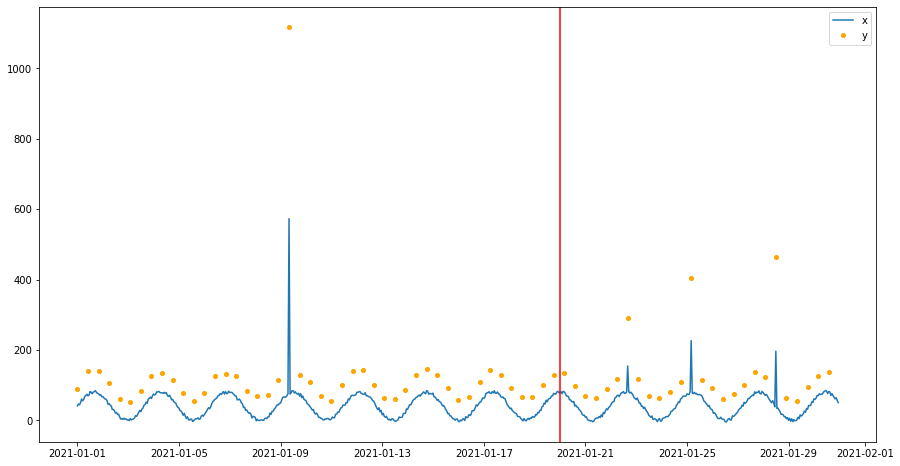

In [45]:
plt.figure(figsize=(15, 8))
x_cols = list(set(df.columns) - set(["time", "y"]))
for col in x_cols:
    plt.plot(df.time, df[col], label=col)
plt.plot(df.time, df.y, "o", markersize=4, label="y", color="orange")
plt.axvline(train_test_split, color="red")
plt.legend()

## Model

In [46]:
model = RandomForestRegressor(n_estimators=200)

## DataFrame splitting into train and test

In [47]:
train_df = df[(df.time < train_test_split) & (~np.isnan(df.y))]
test_df = df[df.time >= train_test_split]

## Do calculation with raw data only

In [48]:
model.fit(train_df.drop(columns=["y", "time"]), train_df.y)
res_raw = model.predict(test_df.drop(columns=["y", "time"]))

## Do augmentation

In [50]:
augmenter = TransformData(target_column="y", time_column="time", N=15, k=10)
augmented_data = augmenter.augment_data(train_df)
print(f"{len(augmented_data)} rows in raw dataset")
print(f"{len(train_df)} raws in augmented dataset")

76 rows in raw dataset
46 raws in augmented dataset


In [51]:
augmented_data.head()

,time,x,y
index,,,
"(0, 0)",2021-01-01 00:00:00,41.059783,90.187172
"(10, 0)",2021-01-01 10:00:00,69.627783,140.285908
"(20, 0)",2021-01-01 20:00:00,75.893350,141.256021
"(30, 0)",2021-01-02 06:00:00,47.366090,106.938249
"(40, 0)",2021-01-02 16:00:00,9.150223,61.355616


In [53]:
model.fit(augmented_data.drop(columns=["y", "time"]), augmented_data.y)
res_augmented = model.predict(test_df.drop(columns=["y", "time"]))

## SMAPE metric estimation

In [54]:
res = pd.DataFrame(
    {
        "time": test_df.time,
        "y": test_df.y,
        "pred_raw": res_raw,
        "pred_augmented": res_augmented,
    }
)
res.head()

,time,y,pred_raw,pred_augmented
456,2021-01-20 00:00:00,NaN,136.797453,144.211141
457,2021-01-20 01:00:00,NaN,136.301507,136.827828
458,2021-01-20 02:00:00,NaN,138.097163,138.915824
459,2021-01-20 03:00:00,NaN,136.301507,136.827828
460,2021-01-20 04:00:00,135.254589,134.650005,134.405625


In [38]:
r = res[~np.isnan(res.y)]
print("smape for raw data:", smape(res.y, res.pred_raw))
print("smape for augmented data:", smape(res.y, res.pred_augmented))

smape for raw data: 0.15119400641774933
smape for augmented data: 0.04600873239210282


## Result visualization

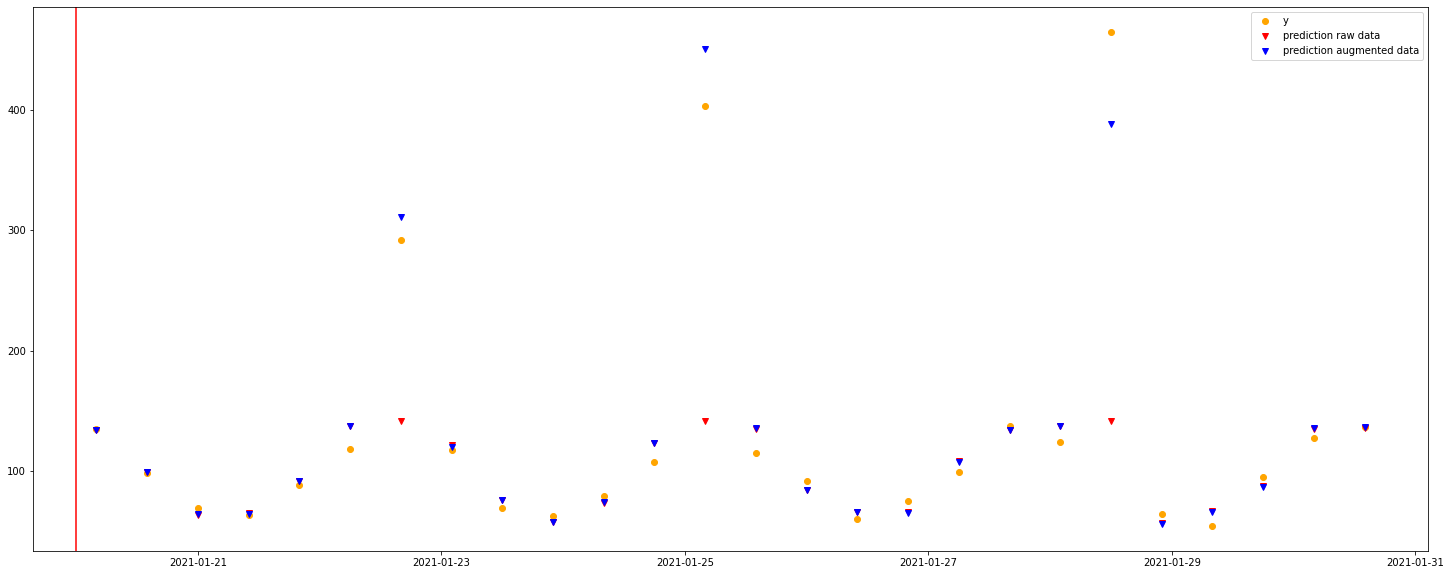

In [55]:
d = res[~np.isnan(res.y)]
plt.figure(figsize=(25, 10))
for col in d.columns:
    if col[0] == "x":
        plt.plot(d.time, d[col], label=col)
plt.plot(d.time, d.y, "o", markersize=6, label="y", color="orange")
plt.plot(d.time, d.pred_raw, "v", markersize=6, label="prediction raw data", color="red")
plt.plot(
    d.time,
    d.pred_augmented,
    "v",
    markersize=6,
    label="prediction augmented data",
    color="blue",
)
plt.axvline(train_test_split, color="red")
plt.legend()
plt.show()